# Importação e Leitura

In [56]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from math import ceil, sqrt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    mean_absolute_error, 
    mean_squared_error,
    silhouette_score,
    make_scorer
)

from scipy import stats
from scipy.stats import chi2_contingency

import duckdb

In [57]:
df = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")
df

/tmp/ipykernel_37562/203287006.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.621790,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212907,10/09/2016,9:30,STATEN ISLAND,10305.0,40.612595,-74.071655,"(40.612595, -74.071655)",NaN,NaN,254 CLIFTON AVENUE,...,NaN,NaN,NaN,NaN,3536789,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
2212908,09/20/2016,12:30,BROOKLYN,11229.0,40.610725,-73.955574,"(40.610725, -73.955574)",NaN,NaN,1804 AVENUE P,...,Unspecified,NaN,NaN,NaN,3527277,Sedan,Sedan,NaN,NaN,NaN
2212909,09/19/2016,13:00,NaN,NaN,40.611767,-73.976380,"(40.611767, -73.97638)",24 AVENUE,NaN,NaN,...,NaN,NaN,NaN,NaN,3523434,Sedan,NaN,NaN,NaN,NaN
2212910,09/28/2016,11:20,NaN,NaN,40.620560,-73.989440,"(40.62056, -73.98944)",63 STREET,NaN,NaN,...,Unspecified,NaN,NaN,NaN,3529408,Station Wagon/Sport Utility Vehicle,Pick-up Truck,NaN,NaN,NaN


## Verificando nulos

In [58]:
df.isnull().sum().sum() # Muitos valores nulos impossivel exclui-los

np.int64(18922504)

In [59]:
df.isna().sum() # colunas off street name, contributing factor 3 veicle ate o 5 , vehicle type code 3 ate o 5 sao colunas com muitos valores nulos
missing_percent = df.isna().mean() * 100
print(missing_percent.sort_values(ascending=False))

VEHICLE TYPE CODE 5              99.561799
CONTRIBUTING FACTOR VEHICLE 5    99.547564
VEHICLE TYPE CODE 4              98.408116
CONTRIBUTING FACTOR VEHICLE 4    98.348556
VEHICLE TYPE CODE 3              93.045860
CONTRIBUTING FACTOR VEHICLE 3    92.765325
OFF STREET NAME                  82.421352
CROSS STREET NAME                38.204095
ZIP CODE                         30.683687
BOROUGH                          30.671260
ON STREET NAME                   21.752966
VEHICLE TYPE CODE 2              20.007935
CONTRIBUTING FACTOR VEHICLE 2    16.022553
LOCATION                         10.858679
LATITUDE                         10.858679
LONGITUDE                        10.858679
VEHICLE TYPE CODE 1               0.723797
CONTRIBUTING FACTOR VEHICLE 1     0.352070
NUMBER OF PERSONS KILLED          0.001401
NUMBER OF PERSONS INJURED         0.000813
CRASH DATE                        0.000000
NUMBER OF PEDESTRIANS INJURED     0.000000
CRASH TIME                        0.000000
NUMBER OF M

## Tratamento de latitude, longitude e bairros

In [60]:
print("Padronização de Texto e Imputação de Coordenadas")

# 1. Padronização de Texto
text_cols = ['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'BOROUGH']

print("Padronizando nomes de ruas para maiúsculo...")
for col in text_cols:
    # Converte para upper e remove espaços
    df[col] = df[col].astype(str).str.upper().str.strip()
    df[col] = df[col].replace({'NAN': np.nan, 'NONE': np.nan})

missing_start = df['LATITUDE'].isna().sum()
print(f"\nNulos iniciais em LATITUDE: {missing_start:,}")

# PASSO 1: Interseção (Rua A & Rua B)
mask_intersection = (df['ON STREET NAME'].notna()) & (df['CROSS STREET NAME'].notna())
df.loc[mask_intersection, 'intersection_key'] = (
    df.loc[mask_intersection, 'ON STREET NAME'] + " & " + 
    df.loc[mask_intersection, 'CROSS STREET NAME']
)

print("1. Tentando imputar por Interseção...")
for col in ['LATITUDE', 'LONGITUDE']:
    df[col] = df[col].fillna(df.groupby('intersection_key')[col].transform('mean'))

# PASSO 2: Ruas Individuais
street_cols = ['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']
for street_col in street_cols:
    print(f"2. Tentando imputar por '{street_col}'...")
    for col in ['LATITUDE', 'LONGITUDE']:
        df[col] = df[col].fillna(df.groupby(street_col)[col].transform('mean'))

# PASSO 3: ZIP CODE
if 'ZIP CODE' in df.columns:
    print("3. Tentando imputar por ZIP CODE...")
    for col in ['LATITUDE', 'LONGITUDE']:
        df[col] = df[col].fillna(df.groupby('ZIP CODE')[col].transform('mean'))

# Limpeza final
if 'intersection_key' in df.columns:
    df = df.drop(columns=['intersection_key'])

missing_end = df['LATITUDE'].isna().sum()
recovered = missing_start - missing_end

print(f"Total recuperado: {recovered:,} ({recovered/missing_start:.1%} dos nulos)")
print(f"Restantes sem coordenada: {missing_end:,}")

Padronização de Texto e Imputação de Coordenadas
Padronizando nomes de ruas para maiúsculo...

Nulos iniciais em LATITUDE: 240,293
1. Tentando imputar por Interseção...
2. Tentando imputar por 'ON STREET NAME'...
2. Tentando imputar por 'CROSS STREET NAME'...
2. Tentando imputar por 'OFF STREET NAME'...
3. Tentando imputar por ZIP CODE...
Total recuperado: 193,261 (80.4% dos nulos)
Restantes sem coordenada: 47,032


In [61]:
# Verifica o padrão dos que sobraram sem Latitude
missing_coords = df[df['LATITUDE'].isna()]

print("Ruas nos dados faltantes:")
print(missing_coords['ON STREET NAME'].value_counts().head())

print("\nZIP CODES nos dados faltantes:")
print(missing_coords['ZIP CODE'].value_counts().head())

Ruas nos dados faltantes:
ON STREET NAME
JACKIE ROBINSON PARKWAY    12
KING PLACE                 11
PLAZA DRIVE                11
MARGARET CORBIN DRIVE      11
W/B BELT PKWY               9
Name: count, dtype: int64

ZIP CODES nos dados faltantes:
ZIP CODE
10044.0    2
Name: count, dtype: int64


In [62]:
print("Limpeza Final e Filtragem Geográfica")

# 1. Criação do df_cleaned removendo linhas sem coordenada
df_cleaned = df.dropna(subset=['LATITUDE', 'LONGITUDE']).copy()

# 2. Remove pontos que caíram fora
lat_min, lat_max = 40.49, 40.92
lon_min, lon_max = -74.26, -73.69

# Máscara para manter apenas o que está DENTRO de NYC
mask_nyc = (
    (df_cleaned['LATITUDE'] >= lat_min) & (df_cleaned['LATITUDE'] <= lat_max) &
    (df_cleaned['LONGITUDE'] >= lon_min) & (df_cleaned['LONGITUDE'] <= lon_max)
)

outliers = (~mask_nyc).sum()
df_cleaned = df_cleaned[mask_nyc].copy()

print(f"Outliers geográficos removidos: {outliers:,}")
print(f"Total final (df_cleaned): {len(df_cleaned):,}")

Limpeza Final e Filtragem Geográfica
Outliers geográficos removidos: 45,732
Total final (df_cleaned): 2,120,148


In [63]:
print("Imputação de bairros via Coordenadas (KNN)")

# 1. Diagnóstico Inicial
missing_borough_start = df['BOROUGH'].isna().sum()
print(f"Nulos iniciais em BOROUGH: {missing_borough_start:,}")

# 2. Preparação dos Dados para o KNN
mask_train = df['BOROUGH'].notna() & df['LATITUDE'].notna() & df['LONGITUDE'].notna()
mask_target = df['BOROUGH'].isna() & df['LATITUDE'].notna() & df['LONGITUDE'].notna()

if mask_target.sum() > 0:
    print(f"Treinando KNN com {mask_train.sum():,} registros...")
    
    # Classificador de 1 vizinho mais próximo 
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    
    # Treino
    X_train = df.loc[mask_train, ['LATITUDE', 'LONGITUDE']]
    y_train = df.loc[mask_train, 'BOROUGH']
    knn.fit(X_train, y_train)
    
    print(f"Prevendo bairros para {mask_target.sum():,} registros...")
    
    # Prevê os bairros faltantes
    X_target = df.loc[mask_target, ['LATITUDE', 'LONGITUDE']]
    predicted_boroughs = knn.predict(X_target)
    
    # Preenche os nulos no DataFrame original
    df.loc[mask_target, 'BOROUGH'] = predicted_boroughs

# 3. Resultado Final
missing_borough_end = df['BOROUGH'].isna().sum()
recovered = missing_borough_start - missing_borough_end

print(f"Bairros recuperados: {recovered:,}")
print(f"Ainda sem bairro (porque não tinham coordenada): {missing_borough_end:,}")

Imputação de bairros via Coordenadas (KNN)
Nulos iniciais em BOROUGH: 678,728
Treinando KNN com 1,534,168 registros...
Prevendo bairros para 631,712 registros...
Bairros recuperados: 631,712
Ainda sem bairro (porque não tinham coordenada): 47,016


In [64]:
print("Preenchendo Colunas de Veículo com 'N/A'")

# Seleção explícita das colunas
vehicle_cols = [
    'VEHICLE TYPE CODE 1', 
    'VEHICLE TYPE CODE 2', 
    'VEHICLE TYPE CODE 3', 
    'VEHICLE TYPE CODE 4', 
    'VEHICLE TYPE CODE 5'
]

# 1. Preenche valores nulos reais (NaN) com 'N/A'
df[vehicle_cols] = df[vehicle_cols].fillna('N/A')

# 2. Garante que tudo é texto e remove 'nan' textual se existir
df[vehicle_cols] = df[vehicle_cols].astype(str).replace(
    {'nan': 'N/A', 'NaN': 'N/A', '<NA>': 'N/A', 'None': 'N/A'}
)

print("\nVerificação (VEHICLE TYPE CODE 1):")
print(df['VEHICLE TYPE CODE 1'].value_counts(dropna=False).head(10))

Preenchendo Colunas de Veículo com 'N/A'

Verificação (VEHICLE TYPE CODE 1):
VEHICLE TYPE CODE 1
Sedan                                  638405
Station Wagon/Sport Utility Vehicle    500271
PASSENGER VEHICLE                      416206
SPORT UTILITY / STATION WAGON          180291
Taxi                                    55613
4 dr sedan                              40186
Pick-up Truck                           38048
TAXI                                    31911
Box Truck                               26420
VAN                                     25266
Name: count, dtype: int64


In [65]:
print("Preenchimento de Nulos")

# 1. Vítimas: Preencher com 0
victim_cols = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']
for col in victim_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

# 2. Causas: Preencher com 'Unspecified'
factor_cols = [
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
    'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
    'CONTRIBUTING FACTOR VEHICLE 5'
]
df[factor_cols] = df[factor_cols].fillna('Unspecified')

# 3. Ruas e CEP: Preencher com 'N/A'
text_cols = ['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'ZIP CODE']
df[text_cols] = df[text_cols].fillna('N/A')

# 4. Location: Redundante
if 'LOCATION' in df.columns:
    df = df.drop(columns=['LOCATION'])

print("Nulos restantes por coluna:")
print(df.isna().sum()[df.isna().sum() > 0])

Preenchimento de Nulos
Nulos restantes por coluna:
BOROUGH      47016
LATITUDE     47032
LONGITUDE    47032
dtype: int64


In [66]:
print("Remoção final")

total_antes = len(df)

# 1. Deleta quem não tem latitude ou longitude
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# 2. Verificação Final
total_depois = len(df)
removidos = total_antes - total_depois

print(f"Linhas removidas: {removidos:,} ({(removidos/total_antes):.1%} do total)")
print(f"Total de linhas restantes: {total_depois:,}")
df_imputed = df

Remoção final
Linhas removidas: 47,032 (2.1% do total)
Total de linhas restantes: 2,165,880


In [67]:
df.isna().sum()
missing_percent = df.isna().mean() * 100
print(missing_percent.sort_values(ascending=False))

CRASH DATE                       0.0
CRASH TIME                       0.0
BOROUGH                          0.0
ZIP CODE                         0.0
LATITUDE                         0.0
LONGITUDE                        0.0
ON STREET NAME                   0.0
CROSS STREET NAME                0.0
OFF STREET NAME                  0.0
NUMBER OF PERSONS INJURED        0.0
NUMBER OF PERSONS KILLED         0.0
NUMBER OF PEDESTRIANS INJURED    0.0
NUMBER OF PEDESTRIANS KILLED     0.0
NUMBER OF CYCLIST INJURED        0.0
NUMBER OF CYCLIST KILLED         0.0
NUMBER OF MOTORIST INJURED       0.0
NUMBER OF MOTORIST KILLED        0.0
CONTRIBUTING FACTOR VEHICLE 1    0.0
CONTRIBUTING FACTOR VEHICLE 2    0.0
CONTRIBUTING FACTOR VEHICLE 3    0.0
CONTRIBUTING FACTOR VEHICLE 4    0.0
CONTRIBUTING FACTOR VEHICLE 5    0.0
COLLISION_ID                     0.0
VEHICLE TYPE CODE 1              0.0
VEHICLE TYPE CODE 2              0.0
VEHICLE TYPE CODE 3              0.0
VEHICLE TYPE CODE 4              0.0
V

# Resolvendo Tipos

In [68]:
df_typed = df_imputed.copy()

# Convertendo colunas que comecam com "NUMBER" para int
number_cols = [col for col in df_typed.columns if col.startswith("NUMBER")]
for col in number_cols:
    df_typed[col] = pd.to_numeric(df_typed[col], errors='coerce').astype('Int64')


df_typed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2165880 entries, 0 to 2212911
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   ON STREET NAME                 object 
 7   CROSS STREET NAME              object 
 8   OFF STREET NAME                object 
 9   NUMBER OF PERSONS INJURED      Int64  
 10  NUMBER OF PERSONS KILLED       Int64  
 11  NUMBER OF PEDESTRIANS INJURED  Int64  
 12  NUMBER OF PEDESTRIANS KILLED   Int64  
 13  NUMBER OF CYCLIST INJURED      Int64  
 14  NUMBER OF CYCLIST KILLED       Int64  
 15  NUMBER OF MOTORIST INJURED     Int64  
 16  NUMBER OF MOTORIST KILLED      Int64  
 17  CONTRIBUTING FACTOR VEHICLE 1  object 
 18  CONTRIB

In [69]:
# Visualizado colunas de datas
date_cols = [col for col in df_typed.columns if 'DATE' in col.upper() or 'TIME' in col.upper()]
print("Date/Time columns found:")
print(date_cols)
print("\nSample values:")
for col in date_cols:
    print(f"\n{col}:")
    print(df_typed[col].head())

Date/Time columns found:
['CRASH DATE', 'CRASH TIME']

Sample values:

CRASH DATE:
0    09/11/2021
1    03/26/2022
2    11/01/2023
3    06/29/2022
4    09/21/2022
Name: CRASH DATE, dtype: object

CRASH TIME:
0     2:39
1    11:45
2     1:29
3     6:55
4    13:21
Name: CRASH TIME, dtype: object


In [70]:
# Conversão de tipos para data e hora
df_typed['CRASH DATE'] = pd.to_datetime(df_typed['CRASH DATE'], format='%m/%d/%Y', errors='coerce')
df_typed['CRASH TIME'] = pd.to_datetime(df_typed['CRASH TIME'], format='%H:%M', errors='coerce').dt.time

# Criação da coluna de dia da semana
df_typed['DAY_OF_WEEK'] = df_typed['CRASH DATE'].dt.day_name()

# Visualização do resultado
print(df_typed[['CRASH DATE', 'CRASH TIME', 'DAY_OF_WEEK']].head())

  CRASH DATE CRASH TIME DAY_OF_WEEK
0 2021-09-11   02:39:00    Saturday
1 2022-03-26   11:45:00    Saturday
2 2023-11-01   01:29:00   Wednesday
3 2022-06-29   06:55:00   Wednesday
4 2022-09-21   13:21:00   Wednesday


In [71]:
# Seleciona colunas 'object', excluindo 'CRASH TIME' (que é datetime.time)
object_cols = df_typed.select_dtypes(include=['object']).columns.tolist()
if 'CRASH TIME' in object_cols:
    object_cols.remove('CRASH TIME')

# Converte as colunas selecionadas para o tipo 'string' de uma só vez
df_typed[object_cols] = df_typed[object_cols].astype('string')

print(f"{len(object_cols)} colunas convertidas para o tipo string.")

16 colunas convertidas para o tipo string.


In [72]:
#versao sem ID e dropando location ja que e a mesma coisa de lat long, alem de renomear o dataset final
df_noid = df_typed.drop(columns=['COLLISION_ID'])
print(df_noid)
df_noid.info()
df_cleaned = df_typed

        CRASH DATE CRASH TIME        BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0       2021-09-11   02:39:00          BRONX      N/A  33.967438 -61.553289   
1       2022-03-26   11:45:00      MANHATTAN      N/A  40.757162 -73.955305   
2       2023-11-01   01:29:00       BROOKLYN  11230.0  40.621790 -73.970024   
3       2022-06-29   06:55:00          BRONX      N/A  40.808303 -73.797393   
4       2022-09-21   13:21:00       BROOKLYN      N/A  40.405489 -73.450636   
...            ...        ...            ...      ...        ...        ...   
2212907 2016-10-09   09:30:00  STATEN ISLAND  10305.0  40.612595 -74.071655   
2212908 2016-09-20   12:30:00       BROOKLYN  11229.0  40.610725 -73.955574   
2212909 2016-09-19   13:00:00       BROOKLYN      N/A  40.611767 -73.976380   
2212910 2016-09-28   11:20:00       BROOKLYN      N/A  40.620560 -73.989440   
2212911 2016-10-01   19:00:00         QUEENS  11355.0  40.751453 -73.832280   

                  ON STREET NAME        CROSS STREE

In [73]:
#dataset final limpo
df_cleaned

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DAY_OF_WEEK
0,2021-09-11,02:39:00,BRONX,N/A,33.967438,-61.553289,WHITESTONE EXPRESSWAY,20 AVENUE,N/A,2,...,Unspecified,Unspecified,Unspecified,4455765,Sedan,Sedan,N/A,N/A,N/A,Saturday
1,2022-03-26,11:45:00,MANHATTAN,N/A,40.757162,-73.955305,QUEENSBORO BRIDGE UPPER,N/A,N/A,1,...,Unspecified,Unspecified,Unspecified,4513547,Sedan,N/A,N/A,N/A,N/A,Saturday
2,2023-11-01,01:29:00,BROOKLYN,11230.0,40.621790,-73.970024,OCEAN PARKWAY,AVENUE K,N/A,1,...,Unspecified,Unspecified,Unspecified,4675373,Moped,Sedan,Sedan,N/A,N/A,Wednesday
3,2022-06-29,06:55:00,BRONX,N/A,40.808303,-73.797393,THROGS NECK BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4541903,Sedan,Pick-up Truck,N/A,N/A,N/A,Wednesday
4,2022-09-21,13:21:00,BROOKLYN,N/A,40.405489,-73.450636,BROOKLYN BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4566131,Station Wagon/Sport Utility Vehicle,N/A,N/A,N/A,N/A,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212907,2016-10-09,09:30:00,STATEN ISLAND,10305.0,40.612595,-74.071655,N/A,N/A,254 CLIFTON AVENUE,0,...,Unspecified,Unspecified,Unspecified,3536789,Station Wagon/Sport Utility Vehicle,N/A,N/A,N/A,N/A,Sunday
2212908,2016-09-20,12:30:00,BROOKLYN,11229.0,40.610725,-73.955574,N/A,N/A,1804 AVENUE P,0,...,Unspecified,Unspecified,Unspecified,3527277,Sedan,Sedan,N/A,N/A,N/A,Tuesday
2212909,2016-09-19,13:00:00,BROOKLYN,N/A,40.611767,-73.976380,24 AVENUE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,3523434,Sedan,N/A,N/A,N/A,N/A,Monday
2212910,2016-09-28,11:20:00,BROOKLYN,N/A,40.620560,-73.989440,63 STREET,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,3529408,Station Wagon/Sport Utility Vehicle,Pick-up Truck,N/A,N/A,N/A,Wednesday


# SQL

In [74]:
# Carrega dados originais para comparação
df_raw = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")

# Bounding box NYC
lat_min, lat_max = 40.49, 40.92
lon_min, lon_max = -74.26, -73.69

# Identifica registros fora dos limites geográficos no dataset original
raw_outlier_mask = (
    (df_raw['LATITUDE'] < lat_min) | (df_raw['LATITUDE'] > lat_max) |
    (df_raw['LONGITUDE'] < lon_min) | (df_raw['LONGITUDE'] > lon_max)
)

print(f"Comparativo de Registros: Raw ({len(df_raw)}) vs Cleaned ({len(df_cleaned)})")
print(f"Outliers de coordenadas detectados no Raw: {raw_outlier_mask.sum()}")

/tmp/ipykernel_37562/3959281846.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")


Comparativo de Registros: Raw (2212912) vs Cleaned (2165880)
Outliers de coordenadas detectados no Raw: 6485


In [75]:
# Criar conexão DuckDB em memória se tiver pouca RAM o bagui fica feio

conn = duckdb.connect(':memory:')

# Registrar no DuckDB
conn.register('crashes_raw', df_raw) 
conn.register('crashes_clean', df_cleaned)

print('Tabelas criadas: crashes_raw, crashes_clean')

Tabelas criadas: crashes_raw, crashes_clean


In [76]:
queries = {
    # 1. Contagem Básica de Registros
    'count_rows_raw': "-- Conta todas as linhas no dataset original\nSELECT COUNT(*) AS total_raw FROM crashes_raw;",
    'count_rows_clean': "-- Conta todas as linhas no dataset limpo (após filtros e remoção de nulos)\nSELECT COUNT(*) AS total_clean FROM crashes_clean;",

    # 2. Contagem Detalhada de Nulos (RAW)
    'nulls_raw': """
        SELECT 
            column_name, 
            SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END) AS nulls, -- Conta quantas vezes o valor é nulo
            COUNT(*) AS total, 
            ROUND(100.0*SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END)/COUNT(*),2) AS pct_null -- Calcula a porcentagem de nulos
        FROM (
            -- Bloco UNION ALL: Empilha verticalmente as colunas de interesse para poder contá-las
            -- O CAST é necessário para compatibilizar os tipos de dados para o empilhamento
            SELECT CAST("CRASH DATE" AS VARCHAR) AS value, 'CRASH DATE' AS column_name FROM crashes_raw UNION ALL
            SELECT CAST("CRASH TIME" AS VARCHAR), 'CRASH TIME' FROM crashes_raw UNION ALL
            SELECT CAST(LATITUDE AS VARCHAR), 'LATITUDE' FROM crashes_raw UNION ALL
            SELECT CAST(LONGITUDE AS VARCHAR), 'LONGITUDE' FROM crashes_raw UNION ALL
            SELECT CAST("NUMBER OF PERSONS INJURED" AS VARCHAR), 'NUMBER OF PERSONS INJURED' FROM crashes_raw UNION ALL
            SELECT CAST("NUMBER OF PERSONS KILLED" AS VARCHAR), 'NUMBER OF PERSONS KILLED' FROM crashes_raw UNION ALL
            SELECT "CONTRIBUTING FACTOR VEHICLE 1", 'CONTRIBUTING FACTOR VEHICLE 1' FROM crashes_raw UNION ALL
            SELECT "CONTRIBUTING FACTOR VEHICLE 2", 'CONTRIBUTING FACTOR VEHICLE 2' FROM crashes_raw UNION ALL
            SELECT "VEHICLE TYPE CODE 1", 'VEHICLE TYPE CODE 1' FROM crashes_raw UNION ALL
            SELECT "VEHICLE TYPE CODE 2", 'VEHICLE TYPE CODE 2' FROM crashes_raw
        ) t 
        GROUP BY column_name 
        ORDER BY pct_null DESC;""",
    
    # 3. Contagem Detalhada de Nulos (CLEAN)
    # Lógica idêntica à anterior, mas rodando no dataset limpo para medir a eficácia da imputação
    'nulls_clean': """
        SELECT column_name, SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END) AS nulls,
               COUNT(*) AS total, ROUND(100.0*SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END)/COUNT(*),2) AS pct_null
        FROM (
          SELECT CAST("CRASH DATE" AS VARCHAR) AS value, 'CRASH DATE' AS column_name FROM crashes_clean UNION ALL
          SELECT CAST("CRASH TIME" AS VARCHAR), 'CRASH TIME' FROM crashes_clean UNION ALL
          SELECT CAST(LATITUDE AS VARCHAR), 'LATITUDE' FROM crashes_clean UNION ALL
          SELECT CAST(LONGITUDE AS VARCHAR), 'LONGITUDE' FROM crashes_clean UNION ALL
          SELECT CAST("NUMBER OF PERSONS INJURED" AS VARCHAR), 'NUMBER OF PERSONS INJURED' FROM crashes_clean UNION ALL
          SELECT CAST("NUMBER OF PERSONS KILLED" AS VARCHAR), 'NUMBER OF PERSONS KILLED' FROM crashes_clean UNION ALL
          SELECT "CONTRIBUTING FACTOR VEHICLE 1", 'CONTRIBUTING FACTOR VEHICLE 1' FROM crashes_clean UNION ALL
          SELECT "CONTRIBUTING FACTOR VEHICLE 2", 'CONTRIBUTING FACTOR VEHICLE 2' FROM crashes_clean UNION ALL
          SELECT "VEHICLE TYPE CODE 1", 'VEHICLE TYPE CODE 1' FROM crashes_clean UNION ALL
          SELECT "VEHICLE TYPE CODE 2", 'VEHICLE TYPE CODE 2' FROM crashes_clean
        ) t 
        GROUP BY column_name 
        ORDER BY pct_null DESC;""",

    # 4. Top Fatores Contribuintes (Comparativo)
    'top_factors_raw': """
        -- Conta os 15 fatores contribuintes mais frequentes no dataset SUJO
        SELECT "CONTRIBUTING FACTOR VEHICLE 1" AS f, COUNT(*) AS c FROM crashes_raw 
        WHERE "CONTRIBUTING FACTOR VEHICLE 1" IS NOT NULL AND TRIM("CONTRIBUTING FACTOR VEHICLE 1") <> '' 
        GROUP BY f ORDER BY c DESC LIMIT 15;""",
    'top_factors_clean': """
        -- Conta os 15 fatores contribuintes mais frequentes no dataset LIMPO (onde esperamos ver maior consistência de nomes)
        SELECT "CONTRIBUTING FACTOR VEHICLE 1" AS f, COUNT(*) AS c FROM crashes_clean 
        WHERE "CONTRIBUTING FACTOR VEHICLE 1" IS NOT NULL AND TRIM("CONTRIBUTING FACTOR VEHICLE 1") <> '' 
        GROUP BY f ORDER BY c DESC LIMIT 15;""",
    
    # 5. Top Tipos de Veículos (Comparativo)
    'vehicle_types_raw': """
        -- Conta os 15 tipos de veículos mais frequentes (RAW)
        SELECT "VEHICLE TYPE CODE 1" AS v, COUNT(*) AS c FROM crashes_raw 
        WHERE "VEHICLE TYPE CODE 1" IS NOT NULL AND TRIM("VEHICLE TYPE CODE 1") <> '' 
        GROUP BY v ORDER BY c DESC LIMIT 15;""",
    'vehicle_types_clean': """
        -- Conta os 15 tipos de veículos mais frequentes (CLEAN - para verificar o efeito da padronização de texto)
        SELECT "VEHICLE TYPE CODE 1" AS v, COUNT(*) AS c FROM crashes_clean 
        WHERE "VEHICLE TYPE CODE 1" IS NOT NULL AND TRIM("VEHICLE TYPE CODE 1") <> '' 
        GROUP BY v ORDER BY c DESC LIMIT 15;""",

    # 6. Agrupamentos Mensais (Tendência Temporal)
    'monthly_raw': """
        -- Agrupa por Ano-Mês usando manipulação de STRING (necessário para dados raw que não são DATE)
        SELECT SUBSTRING("CRASH DATE", 7, 4) || '-' || SUBSTRING("CRASH DATE", 1, 2) AS ym, COUNT(*) AS cnt 
        FROM crashes_raw 
        WHERE "CRASH DATE" IS NOT NULL 
        GROUP BY ym ORDER BY ym;""",
    'monthly_clean': """
        -- Agrupa por Mês usando a função DATE_TRUNC (mais robusta, pois o dado já foi convertido para tipo DATE/DATETIME)
        SELECT DATE_TRUNC('month', "CRASH DATE")::VARCHAR AS ym, COUNT(*) AS cnt 
        FROM crashes_clean 
        WHERE "CRASH DATE" IS NOT NULL 
        GROUP BY ym ORDER BY ym;"""
}

# Execução e armazenamento dos resultados
results = {}
for name, q in queries.items():
    results[name] = conn.execute(q).df()
    print(f"-- {name}\n{results[name].head()}\n")

# Variáveis para uso posterior
monthly_raw = results['monthly_raw']
monthly_clean = results['monthly_clean']
nulls_raw = results['nulls_raw']
nulls_clean = results['nulls_clean']
veh_raw = results['vehicle_types_raw']
veh_clean = results['vehicle_types_clean']

-- count_rows_raw
   total_raw
0    2212912

-- count_rows_clean
   total_clean
0      2165880

-- nulls_raw
                     column_name     nulls    total  pct_null
0            VEHICLE TYPE CODE 2  442758.0  2212912     20.01
1  CONTRIBUTING FACTOR VEHICLE 2  354565.0  2212912     16.02
2                       LATITUDE  240293.0  2212912     10.86
3                      LONGITUDE  240293.0  2212912     10.86
4            VEHICLE TYPE CODE 1   16017.0  2212912      0.72

-- nulls_clean
                     column_name  nulls    total  pct_null
0                     CRASH TIME    0.0  2165880       0.0
1                       LATITUDE    0.0  2165880       0.0
2                     CRASH DATE    0.0  2165880       0.0
3  CONTRIBUTING FACTOR VEHICLE 2    0.0  2165880       0.0
4       NUMBER OF PERSONS KILLED    0.0  2165880       0.0

-- top_factors_raw
                                f       c
0                     Unspecified  741277
1  Driver Inattention/Distraction  448851
2  

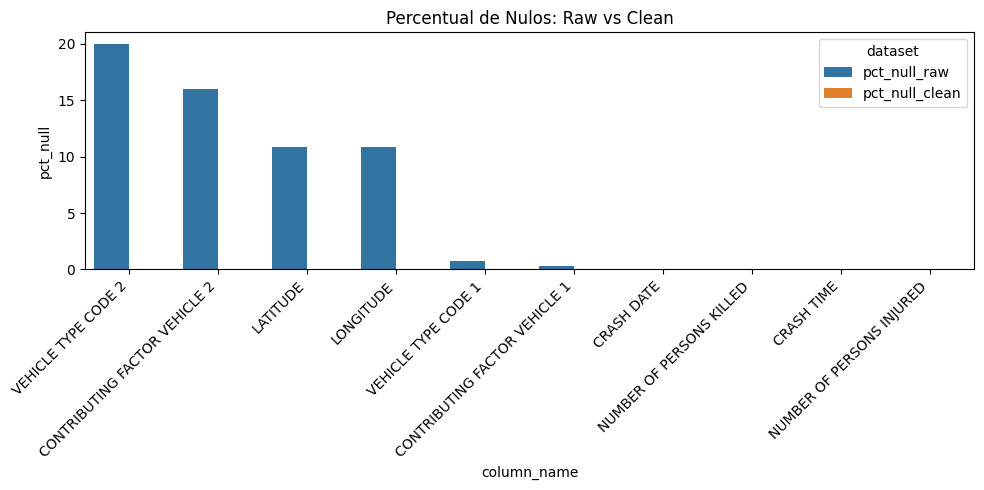

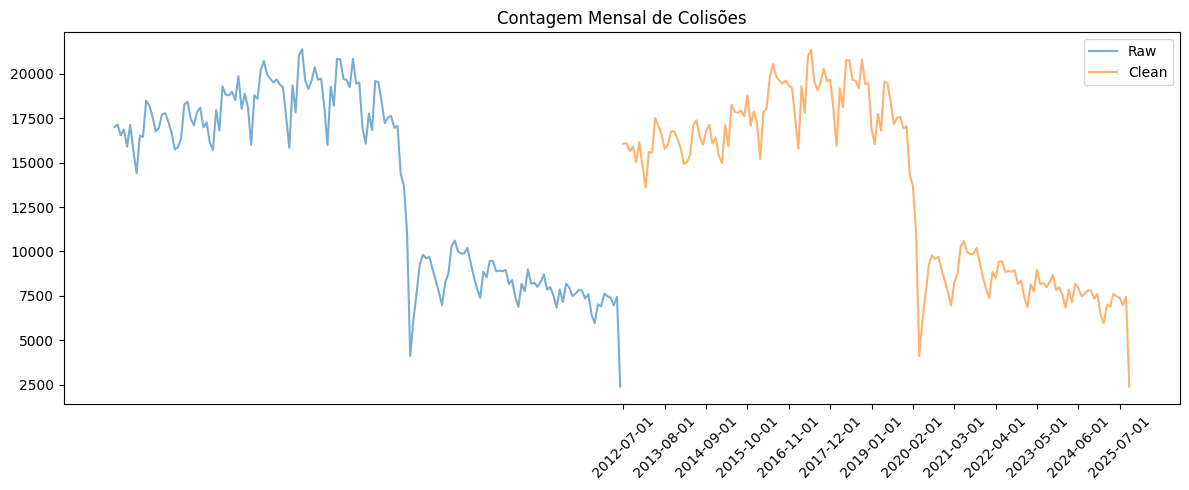

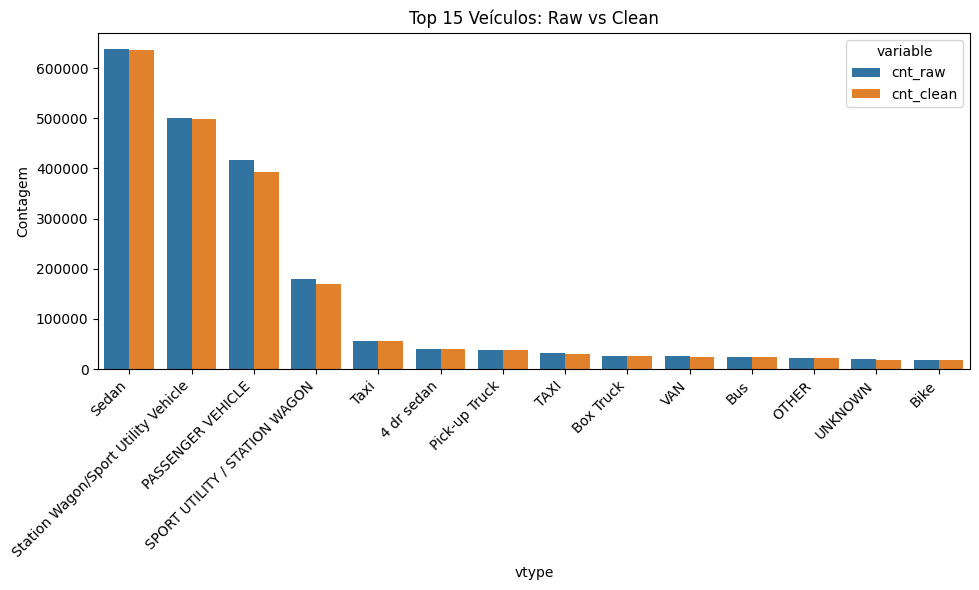

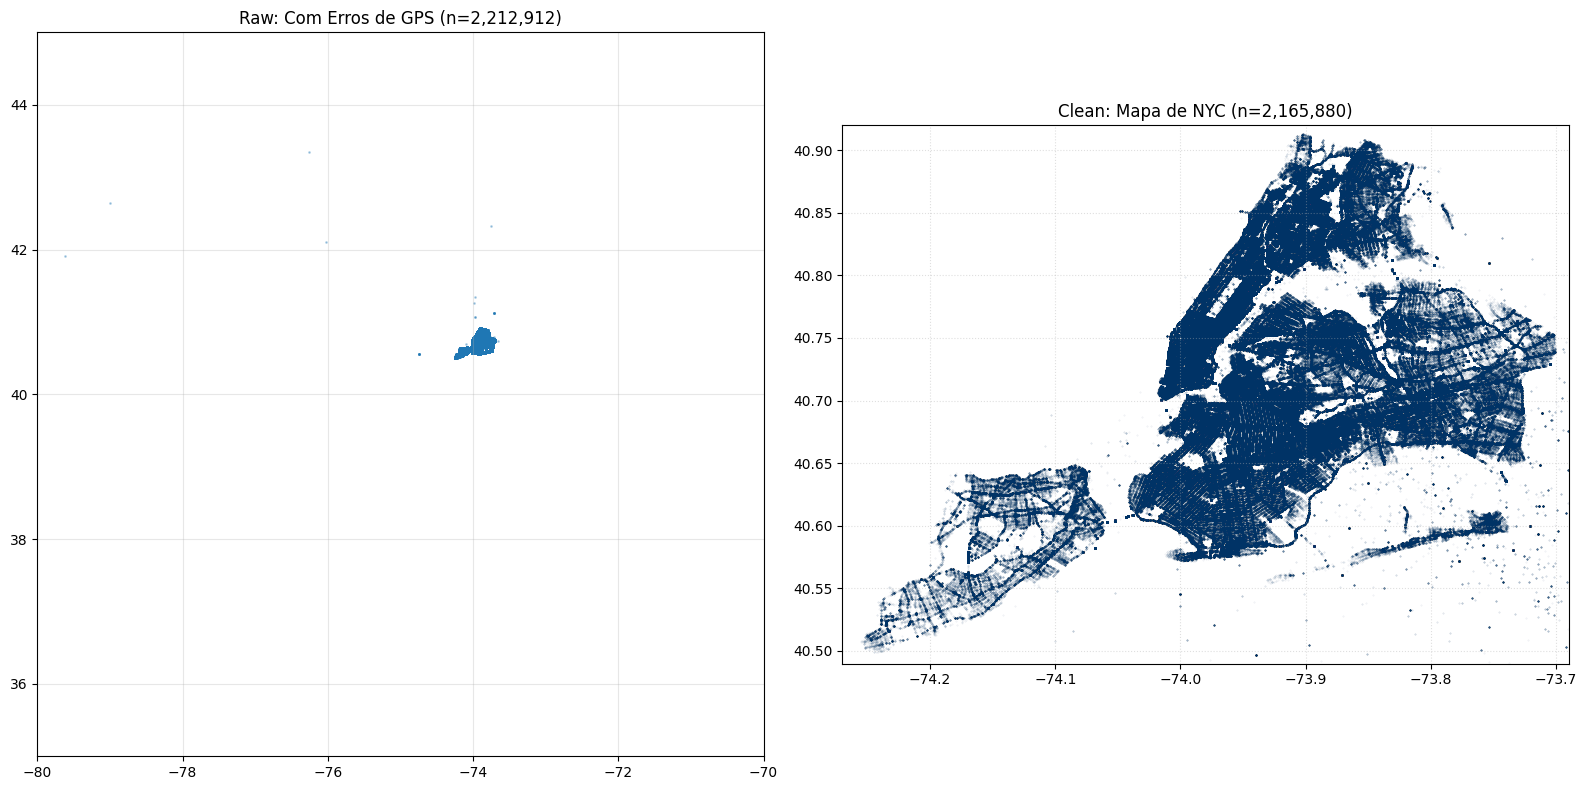

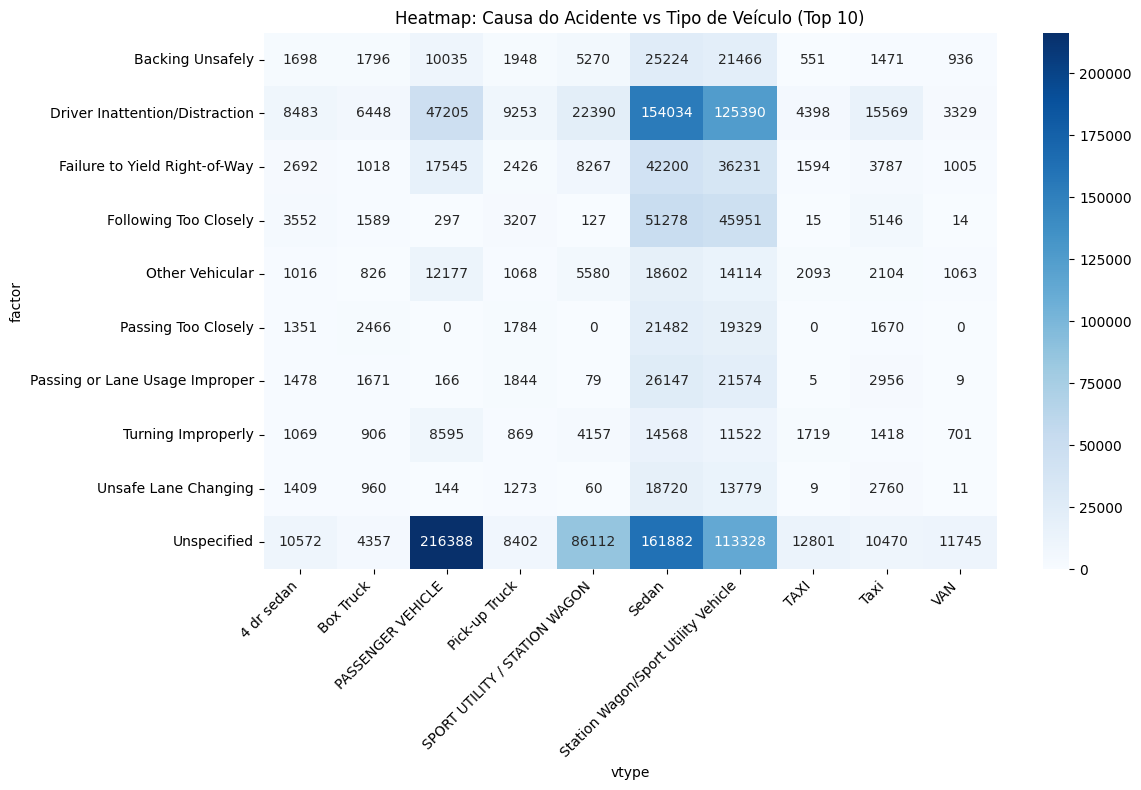

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

#1. Raw vs Clean
miss_compare = nulls_raw[['column_name','pct_null']].merge(
    nulls_clean[['column_name','pct_null']], on='column_name', suffixes=('_raw','_clean')
)

plt.figure(figsize=(10,5))
sns.barplot(data=miss_compare.melt(id_vars='column_name', value_name='pct_null', var_name='dataset'), 
            x='column_name', y='pct_null', hue='dataset')
plt.xticks(rotation=45, ha='right'); plt.title('Percentual de Nulos: Raw vs Clean'); plt.tight_layout(); plt.show()

# 2. Evolução Mensal 
plt.figure(figsize=(12,5))
plt.plot(monthly_raw['ym'], monthly_raw['cnt'], label='Raw', alpha=0.6)
plt.plot(monthly_clean['ym'], monthly_clean['cnt'], label='Clean', alpha=0.6)
plt.xticks(monthly_clean['ym'][::max(len(monthly_clean)//12, 1)], rotation=45)
plt.title('Contagem Mensal de Colisões'); plt.legend(); plt.tight_layout(); plt.show()

# 3. Top Tipos de Veículo 
veh_raw = veh_raw.rename(columns={'v': 'vtype', 'c': 'cnt'})
veh_clean = veh_clean.rename(columns={'v': 'vtype', 'c': 'cnt'})

veh_merge = veh_raw.merge(veh_clean, on='vtype', suffixes=('_raw','_clean'))
veh_sorted = veh_merge.sort_values('cnt_clean', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=veh_sorted.melt(id_vars='vtype', value_vars=['cnt_raw','cnt_clean']), 
            x='vtype', y='value', hue='variable')
plt.xticks(rotation=45, ha='right'); plt.title('Top 15 Veículos: Raw vs Clean'); plt.ylabel('Contagem'); plt.tight_layout(); plt.show()

# 4. Coordenadas Geográficas 
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(df_raw['LONGITUDE'], df_raw['LATITUDE'], s=1, alpha=0.3)
axes[0].set_title(f'Raw: Com Erros de GPS (n={len(df_raw):,})')
axes[0].set_xlim(-80, -70) # Zoom out
axes[0].set_ylim(35, 45)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df_cleaned['LONGITUDE'], df_cleaned['LATITUDE'], 
                s=0.1, alpha=0.1, color='#003366') 
axes[1].set_title(f'Clean: Mapa de NYC (n={len(df_cleaned):,})')

axes[1].set_xlim([-74.27, -73.69]) 
axes[1].set_ylim([40.49, 40.92])
axes[1].set_aspect('equal') 
axes[1].grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()
# 5. Heatmap (Fatores x Tipos)
df_heat = conn.execute("""
    SELECT "CONTRIBUTING FACTOR VEHICLE 1" AS factor, "VEHICLE TYPE CODE 1" AS vtype
    FROM crashes_clean
    WHERE factor IS NOT NULL AND vtype IS NOT NULL AND TRIM(factor)<>'' AND TRIM(vtype)<>''
""").df()

top_factors = df_heat['factor'].value_counts().head(10).index
top_vtypes = df_heat['vtype'].value_counts().head(10).index
pivot = pd.crosstab(df_heat[df_heat['factor'].isin(top_factors)]['factor'], 
                    df_heat[df_heat['vtype'].isin(top_vtypes)]['vtype'])

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap='Blues', annot=True, fmt='d')
plt.title('Heatmap: Causa do Acidente vs Tipo de Veículo (Top 10)'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()